# Classification of Podium Finishing at HKJC
In this section, we will be generating a Categorical Naive Bayes Model that attempts to predict whether a horse finishes on the podium (1st place, 2nd place, or 3rd place) in any given race. Predicting podium finishes is a giant portion of the HKJC betting market. This model will hopefully serve as the basis for making more complex predictions later on in this project.

In [1]:
import pandas as pd
import numpy as np
import scipy
import sklearn 
import seaborn as sns

In [2]:
# Reading in our data
horses = pd.read_csv('../../../data/01-modified-data/horses.clean.csv')
perf = pd.read_csv('../../../data/01-modified-data/perf.clean.csv')

/tmp/ipykernel_214653/2292367370.py:3: DtypeWarning: Columns (9,17,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  perf = pd.read_csv('../../../data/01-modified-data/perf.clean.csv')


We are now going to join horse attributes from the horses data set with the performance dataset.

In [3]:
# Need to join color, sex, and import type with perf data. Then, create a race_length variable, along with a column that outputs 1 or 0 for podium finish.
# Data can then be cleaned to only include features of interest.

perf_clean = pd.merge(perf,horses[["horse_id","colour","sex","import_type"]],on="horse_id",how = "inner")

Now we are going to create a variable "podium" that is equal to 1 if a horse placed in the top 3 and 0 if it did not. This variable is what we will be trying to classify with a Bernoulli Naive Bayes Classifier.

In [4]:
perf_clean['podium'] = np.nan
for i in range(len(perf_clean["final_placing"])):   
    if perf_clean["final_placing"][i] == 1 or perf_clean["final_placing"][i] == 2 or perf_clean["final_placing"][i] == 3:
        perf_clean['podium'][i] = 1
    else:
        perf_clean['podium'][i] = 0

/tmp/ipykernel_214653/1377842129.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_clean['podium'][i] = 0
/tmp/ipykernel_214653/1377842129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_clean['podium'][i] = 1


Now we will create a subset of data with our features of interest. Our features of interest are all of our categorical variables.

In [5]:
perf_classifier = perf_clean[['podium','colour','sex','import_type','draw','rating']]
perf_classifier = perf_classifier.dropna()

One important point to note is that we will not be looking at finishing time as a classifier of podium finishing as we want to create a classifier model that can take features related to a horse that can be recorded BEFORE a horse runs a race. Mean or median finishing time at various race distances could be used, but such a measurement is mostly taken into account with the horse rating variable.

With our feature set, we must now dummy code our categorical features.

In [6]:
from sklearn import preprocessing

perf_classifier_encode = perf_classifier.loc[:,perf_classifier.columns != 'draw']

perf_classifier_encode = perf_classifier_encode.apply(preprocessing.LabelEncoder().fit_transform)
perf_classifier_encode = pd.DataFrame(perf_classifier_encode)
perf_classifier_encode['draw'] = perf_classifier['draw']

In [7]:
perf_classifier_encode.head(3)

,podium,colour,sex,import_type,rating,draw
0,0,0,3,1,72,13
1,0,0,3,1,72,6
2,0,0,3,1,71,1


## Feature Selection for Categorical Naive Bayes

Now we will define our feature set, which is all categorical variables, and dependent variable, y (podium).

In [8]:
x = np.array(perf_classifier_encode.loc[:, perf_classifier_encode.columns != 'podium'])
y = np.array([perf_classifier_encode['podium']])
y = y.transpose()

In [9]:
import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
cut2 = int((N - cut)/2 + cut)
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
validate_index = l[cut:cut2] # 10% of shuffled list
test_index = l[cut2:] # 10% of shuffled list

print(train_index[0:10])
print(validate_index[0:10])
print(test_index[0:10])

[190473, 156129, 137523, 260254, 183039, 203843, 146247, 37677, 110245, 252270]
[42082, 84359, 217230, 177108, 97894, 52494, 71092, 65024, 108345, 176631]
[24596, 221411, 33609, 119048, 182087, 69609, 81023, 11185, 186924, 203706]


In [10]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
import time

# Defining a function that generates a NB model
def train_CNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = CategoricalNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_CNB_model(x,y,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(266164, 5) (266164, 1)
(266164, 5) (266164, 1)
74.74909712535985 74.94082729082918 0.057764799999993954 0.018997599999998727


In [11]:
##UTILITY FUNCTION TO INITIALIZE RELEVANT ARRAYS
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]

In [12]:
# INITIALIZE ARRAYS
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_CNB_model(xtmp,y,i_print=False)

        
        print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=5, min_index=0)



1 1 1 74.70448173351932 74.91828530638314
2 2 2 74.70448173351932 74.91828530638314
3 3 3 74.70448173351932 74.91828530638314
4 4 4 74.74111331839892 74.9370702934215
5 5 5 74.74909712535985 74.94082729082918


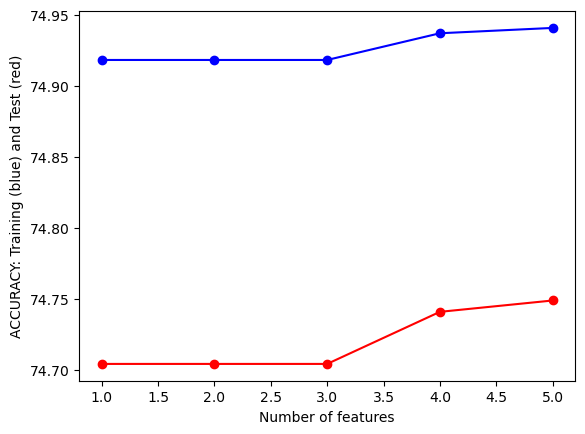

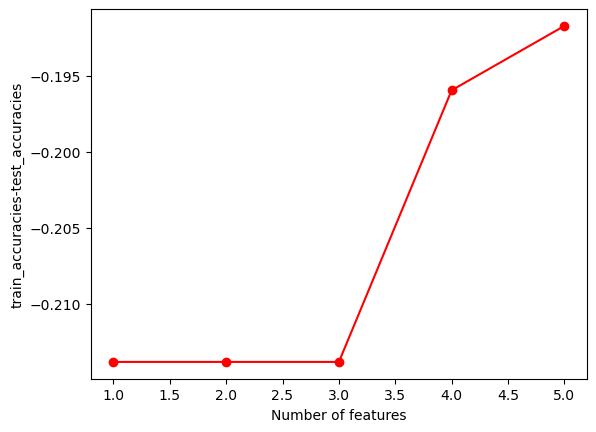

In [13]:
import matplotlib.pyplot as plt
plt.plot(num_features,train_accuracies,'-or')
plt.plot(num_features,test_accuracies,'-ob')
plt.xlabel('Number of features')
plt.ylabel('ACCURACY: Training (blue) and Test (red)')
plt.show()

plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
plt.xlabel('Number of features')
plt.ylabel('train_accuracies-test_accuracies')
plt.show()

We can see that our model becomes more accurate when draw and ranking are added as features, with a larger jump in accuracy when draw is included as a feature.

In [14]:
import itertools
best_acc = 0
m = x.shape[1]

for i in range(1, m + 1):
          subset = itertools.combinations(range(m),i)

          for j in subset:
               x_subset = x[:,j]
               (acc_train,acc_test,time_train,time_eval)=train_CNB_model(x_subset,y,i_print=False)

               if acc_test > best_acc:
                    best_acc = acc_test
                    best_subset = x_subset

print(best_subset)

[[ 1 72]
 [ 1 72]
 [ 1 71]
 ...
 [ 3 55]
 [ 3 63]
 [ 3 60]]


The best subset of features are sex, rating, and draw.

## Fitting a Final, "Optimal" NB Model
We will now use our subset of features to fit a final NB model. Our training model, consisting of the optimal feature set, will take a split of test data from the original dataset in order to give the model "unseen" data with classfication labels we already know, so that we can develop accurate metrics surroudning the performance of our model.

In [15]:
x = np.array(perf_classifier_encode[['sex','draw','rating']])
y = np.array([perf_classifier_encode['podium']])
y = y.transpose()

In [16]:
import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
cut2 = int((N - cut)/2 + cut)
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
validate_index = l[cut:cut2] # 10% of shuffled list
test_index = l[cut2:] # 10% of shuffled list

In [326]:
(acc_train,acc_test,time_train,time_eval)=train_CNB_model(x,y,i_print=True)

(266164, 3) (266164, 1)
74.83644936622662 74.76049141526092 0.0715845999998237 0.03521339999997508


We can see above that our model has a test accuracy of 74.83% and has a test accuracy of 74.76% which is fairly strong. Because both our training and test accuracies are very close in magnitude with the test accuracy being slightly larger, we can conclude that our model is definitely not overfit as the test accuracy would be much lower if this were the case. There might be the argument that our model underfits the data because our test accuracy is so close to the train accuracy, and as you will see later, our F-1 score is pretty abysmal. We explore this idea in a little bit.

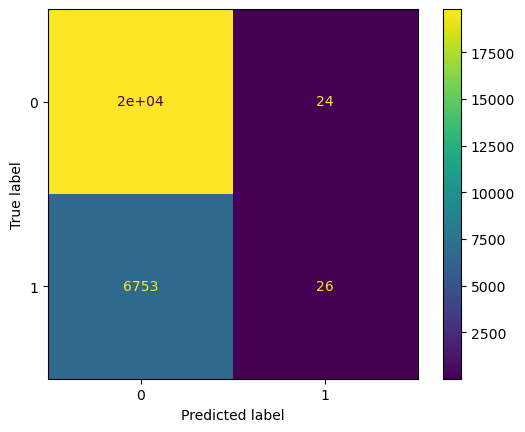

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
x_train=x[train_index]
y_train=y[train_index].flatten()

x_test=x[test_index]
y_test=y[test_index].flatten()

clf = CategoricalNB()
clf.fit(x_train,y_train)

yp_test = clf.predict(x_test)
cm = confusion_matrix(y_test, yp_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
Accuracy = metrics.accuracy_score(y_test, yp_test)
Precision = metrics.precision_score(y_test, yp_test)
Sensitivity = metrics.recall_score(y_test, yp_test)
Specificity = metrics.recall_score(y_test, yp_test,pos_label=0)
F1_score = metrics.f1_score(y_test, yp_test)
print("Accuracy:",Accuracy*100)
print("Precision:", Precision*100)
print("Sensitivity:",Sensitivity*100)
print("Specificity:",Specificity*100)
print("F1 Score:",F1_score*100)

Accuracy: 74.53882856820829
Precision: 52.0
Sensitivity: 0.38353739489600236
Specificity: 99.8790200625063
F1 Score: 0.7614584858690876


 We can notice a few things. First of all, our model is about 75% accurate which is very strong. At the surface level, our precision is also fairly strong at around 60%. Of the horse podium finishers predicted, our model predicts correctly predicts them as podium finishers 60% of the time. HOWEVER, our confusion matrix shows that our model only predicted 27 out of the over 20,0000 observations as correctly positive podium finishers. We can see in the confusion matrix that the model is REALLY good at predicting non-podium finishers with a specificity of around 99%. This characteristic is not really impressive in practicality, however, as we are really just interested in predicting horse podium finishers. Resultantly, our ability in predicting positive results is very low, with an EXTREMELY low sensitity score. Our F-1 score is also VERY low, showing that this model is overall not very effective at all for predicting horse racing podium finishes. This characteristic is also an indication that our model is very underfitted as we are not capturing all neccessary patterns and behaviors neccessary for correctly prediciting podium finishes.

## Conclusion
Overall, our model is not a great overall tool for predicting horse podium finishers (this might be a little bit of an understatement). What is a valuable takeaway from this exercise, however, is we can very strongly observe what characteristics drive a horse to NOT finsh on the podium. A horse's attributes like color and import type (which delineate what type of horse we are observing) really do not have any impact on the probability a horse has a podium finish. A horse's sex (i.e. if it is a colt, philly, mare, adolescent, or adult) can, however, be used to help inform if a horse will likely not finish on the podium. Rating and draw are the most important features here. Our model is able to show us that given a horse's draw and rating, we can discount its likelihood to finish on the podium if its draw and rating are below a certain threshold. While this threshold is not clearly defined yet, this phenomena does allow us to understand that draw and rating will be important features as we continue to try and predict horse performance with more advanced statistical methods. These findings will be reported in the final conclusive report generated for this project, along with being used as the basis for much of the feature selection as we go forth developing more advanced models in this project.